In [33]:
import os
import numpy as np
from numba import jit, njit
from scipy.integrate import odeint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# from matplotlib.ticker import MaxNLocator

from IPython.display import display

sns.set()
sns.set_style("white")
sns.set_style('ticks')

# %matplotlib ipympl
# mpl.rcParams['figure.dpi'] = 150
# # mpl.rcParams["figure.figsize"] = (3,1)
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.family'] = "serif"
# mpl.rcParams['text.latex.preamble'] = r"\usepackage{lmodern}"

home = os.environ['HOME']
plt.style.use(f"{home}/Dropbox/Oceanography/hpc-tools/wit/wit.mpl")

mm = 1/25.4 ## mm to inches conversion

In [34]:
@jit
def coral_ode(p, t, Γ, I):
    """System of ODE's to be solved"""
    #_numba_'s @jit decorator is used to optimize performance as this function will be called many times over the course of the optimization routine
    n = len(p)
    dp = np.zeros((n))
    
    for i in range(n):
        dp[i] = ( np.dot( Γ[:,i], p)        )*(1 - p[i])

    return dp


In [35]:
@jit
def coral_ode_dia(p, t, Γ, I):
    """System of ODE's to be solved"""
    #_numba_'s @jit decorator is used to optimize performance as this function will be called many times over the course of the optimization routine
    
    n =  int( len(p) / 2)

    
    dp = np.zeros((2*n))

    for i in range(n):
        j = i + n
        cff = 1 - (p[i] + p[j]) 
        dp[i] = ( np.dot( Γ[:,i].T, p[:n])        )*cff
    
    for j in range(n,2*n):
        i = j - n
        cff = 1 - (p[i] + p[j]) 
        dp[j] = ( np.dot( Γ[:,i].T, p[n:]) + I[i] )*cff

    return dp



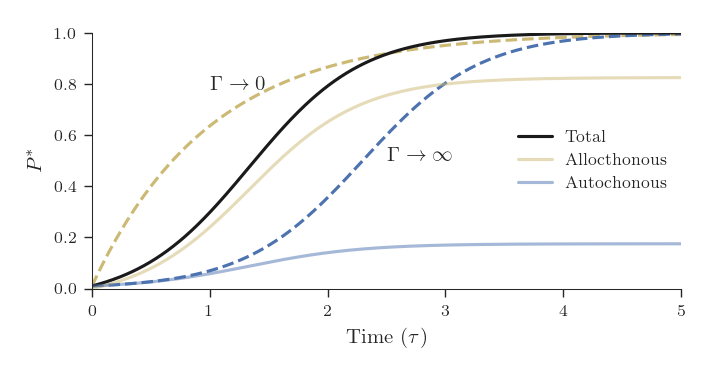

In [44]:
t = np.linspace(0,10,1000)

plt.close("all")
#fig, ax = plt.subplots(1,1, squeeze = False, sharex = True, figsize =  ( 129*mm, 60*mm) ) #+ 0.2 + 1/30
fig, ax = plt.subplots(1,1, squeeze = False, sharex = True, figsize =  ( 4.75, 2.5), dpi = 150 ) #+ 0.2 + 1/30
ax = ax.flatten()


# All immigration

Γ = 0.0*np.ones( (2,2) )
I =  np.array([1,1])
p0 = np.array([0.01,0.01,0,0])

args = (Γ, I)
sol = odeint(coral_ode_dia, y0 = p0,  t = t, args = args) #solve ODE

#ax[0].plot(t,sol, color = "k", linestyle = "-")
total = np.sum(sol, axis = 1)/2
ax[0].plot(t, total, color = "y", linestyle = "--", linewidth = 1.5)#, label = r"$\Gamma \rightarrow \infty$")

# All intrinsic growth

Γ = 1*np.ones( (2,2) )
I =  np.array([0.0,0.0])
p0 = np.array([0.01,0.01,0,0])

args = (Γ, I)
sol = odeint(coral_ode_dia, y0 = p0,  t = t, args = args) #solve ODE
total = np.sum(sol, axis = 1)/2

#ax[0].plot(t, sol, color = "k",  linestyle = "--")
#ax[0].plot(t, total, color = "k")
ax[0].plot(t, (sol[:,0] + sol[:,1])/2, color = "b", linestyle = "--", linewidth = 1.5)#, label = r"$\Gamma \rightarrow 0$" )

# Intermediate

Γ = 1*np.ones( (2,2) )
I =  np.array([1,1])/10
p0 = np.array([0.01,0.01,0,0])

args = (Γ, I)
sol = odeint(coral_ode_dia, y0 = p0,  t = t, args = args) #solve ODE

#ax[0].plot(t,sol, color = "k", linestyle = "-")
total = np.sum(sol, axis = 1)/2
ax[0].plot(t, total, color = "k", linestyle = "-", label = "Total")
ax[0].plot(t, (sol[:,2] + sol[:,3])/2, color = "y", alpha = 0.5, linestyle = "-", label = "Allocthonous")
ax[0].plot(t, (sol[:,0] + sol[:,1])/2, color = "b", alpha = 0.5, linestyle = "-", label = "Autochonous")

#Tidy up plot

ax[0].legend(frameon = False, loc = "right", fontsize = 8)
           
ax[0].text(1, 0.775, r"$\Gamma \rightarrow 0$", fontdict = dict(fontsize = 10))
ax[0].text(2.5, 0.5, r"$\Gamma \rightarrow \infty$", fontdict = dict(fontsize = 10))

# ax[0].text(0.8, 0.8, r"$\Gamma \rightarrow 0$", fontdict = dict(fontsize = 10))
# ax[0].text(2.1, 0.3, r"$\Gamma \rightarrow \infty$", fontdict = dict(fontsize = 10))

tick_kwargs = dict(labelsize = 8, length = 4, width = 2/3)
ax[0].tick_params(**tick_kwargs)


for axis in ax:
    axis.set_xlim(0,5)
    axis.set_ylim(0,1.0)
    axis.set_xlabel(r"Time ($\tau$)", fontsize = 10)
    axis.set_ylabel(r"$P^*$", fontsize = 10)
    #axis.tick_params(labelsize = 8)
    
sns.despine(fig)
fig.tight_layout()

In [46]:
fig.savefig("theoretical.pdf", bbox_inches = "tight", dpi = 300)